In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import collections.abc

# Backward compatibility for causalgraphicalmodels (expects collections.Iterable)
if not hasattr(collections, "Iterable"):
    collections.Iterable = collections.abc.Iterable

from causalgraphicalmodels import CausalGraphicalModel
import statsmodels.api as sm
from graphviz import Source
from scipy import stats
import os

## Part 1a - Real life examples (2 points)

**Confounder:**  Una variable que afecta tanto al tratamiento como al resultado, creando una asociación espuria. Si no se controla, puede llevar a estimaciones sesgadas del efecto causal.
Collider: Una variable que es afectada tanto por el tratamiento como por el resultado (o variables en el camino causal). Controlar por un colisionador puede introducir sesgo.
Mediator: Una variable que se encuentra en el camino causal entre el tratamiento y el resultado. El tratamiento afecta al mediador, el cual a su vez afecta al resultado"

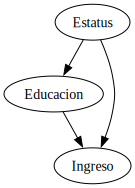

✅ DAG mostrado correctamente en Jupyter Notebook.


In [11]:
"""
Efecto de la Educación en los Ingresos
Tratamiento (X): Años de Educación
Resultado (Y): Ingreso Anual
Variable Confusora (Z): Estatus Socioeconómico Familiar
El origen familiar afecta tanto las oportunidades educativas como el potencial de ingresos
"""



# ===== Crear el DAG =====
confounder_dag = CausalGraphicalModel(
    nodes=["Estatus", "Educacion", "Ingreso"],
    edges=[
        ("Estatus", "Educacion"),
        ("Estatus", "Ingreso"),
        ("Educacion", "Ingreso")
    ]
)

# ===== Dibujar el DAG =====
dag_source = confounder_dag.draw()

# ===== Detectar entorno y mostrar/guardar =====
def mostrar_dag(dag_source, filename="./output/confounder"):
    """
    Muestra el DAG en Jupyter o lo guarda como PNG si se ejecuta desde script.
    """
    try:
        # Verificar si estamos en Jupyter
        get_ipython()
        from IPython.display import display
        display(dag_source)
        print("✅ DAG mostrado correctamente en Jupyter Notebook.")
    except NameError:
        # Si no hay entorno interactivo, guardar como archivo PNG
        output_path = os.path.join(os.getcwd(), f"{filename}.png")
        dag_source.render(filename=filename, format="png", cleanup=True)

# ===== Ejecutar la función =====
mostrar_dag(dag_source)


**Collider :** Una variable que afecta tanto al tratamiento como al resultado, creando una asociación espuria. Si no se controla, puede llevar a estimaciones sesgadas del efecto causal.
Collider: Una variable que es afectada tanto por el tratamiento como por el resultado (o variables en el camino causal). Controlar por un colisionador puede introducir sesgo.
Mediator: Una variable que se encuentra en el camino causal entre el tratamiento y el resultado. El tratamiento afecta al mediador, el cual a su vez afecta al resultado

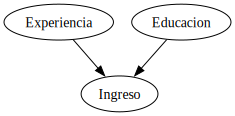

✅ DAG mostrado correctamente en Jupyter Notebook.


In [7]:
# ===== Crear el DAG =====
confounder_dag = CausalGraphicalModel(
    nodes=["Experiencia", "Educacion", "Ingreso"],
    edges=[
        ("Experiencia", "Ingreso"),
        ("Educacion", "Ingreso")
    ]
)

# ===== Dibujar el DAG =====
dag_source_colider = confounder_dag.draw()
mostrar_dag(dag_source_colider, filename="collider_dag")

## Mediation

✅ DAG guardado como ../output/mediator.png


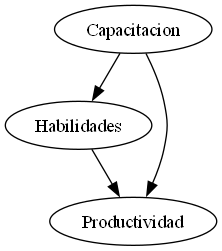

In [12]:
"""
Efecto de la Capacitación en la Productividad a través de Habilidades
Tratamiento (X): Programa de Capacitación Laboral
Resultado (Y): Productividad del Trabajador
Mediador (Z): Nivel de Habilidades
La capacitación mejora las habilidades, las cuales mejoran la productividad.
"""

from causalgraphicalmodels import CausalGraphicalModel
import graphviz
import os

# ===== Crear el DAG =====
mediator_dag = CausalGraphicalModel(
    nodes=["Capacitacion", "Habilidades", "Productividad"],
    edges=[
        ("Capacitacion", "Habilidades"),
        ("Habilidades", "Productividad"),
        ("Capacitacion", "Productividad")
    ]
)

# ===== Generar código DOT =====
dot_code = mediator_dag.draw().source

# ===== Crear y guardar el gráfico =====
output_path = "../output/mediator"
graph = graphviz.Source(dot_code)
graph.render(filename=output_path, format="png", cleanup=True)

print(f"✅ DAG guardado como {output_path}.png")

# ===== Mostrar en Jupyter (opcional) =====
try:
    from IPython.display import Image, display
    display(Image(filename=f"{output_path}.png"))
except:
    pass


## 1b)  Paradoja de Simpson
-------------------
La Paradoja de Simpson ocurre cuando una tendencia aparece en diferentes grupos de datos 
pero desaparece o se invierte cuando los grupos se combinan. 
Esto sucede debido a la presencia de una variable confusora que afecta tanto 
a la variable explicativa como al resultado de manera diferente entre grupos.

In [14]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import os

Pendiente Grupo 1: 0.569
Pendiente Grupo 2: 0.402
Pendiente Combinada: -0.334


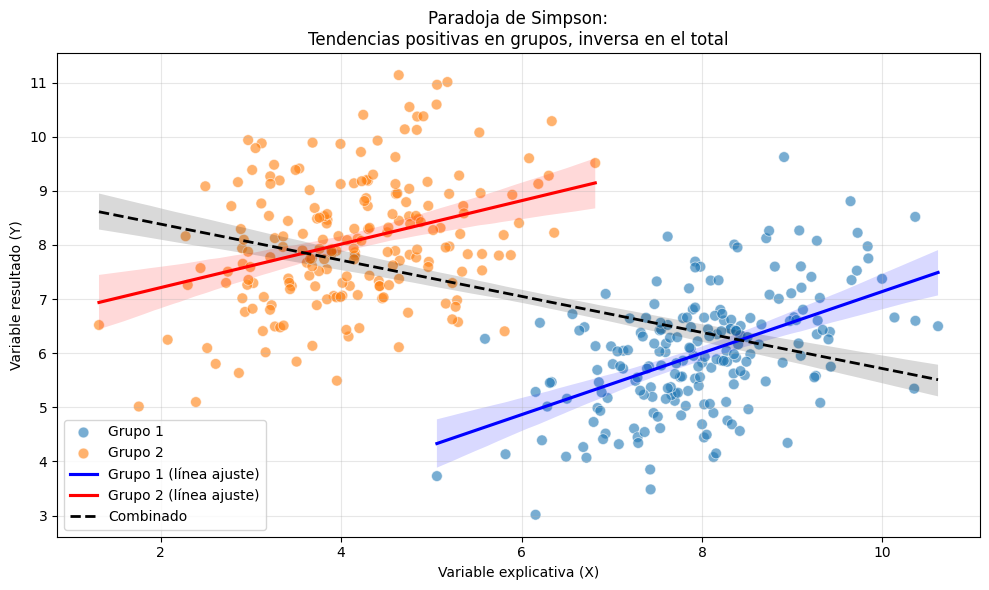

In [15]:
# ===== Simulación de datos =====
n_por_grupo = 200  

# Grupo 1: X alto, relación positiva
grupo1 = pd.DataFrame({
    "grupo": "Grupo 1",
    "x": np.random.normal(8, 1, n_por_grupo),      # X con media alta
    "epsilon": np.random.normal(0, 1, n_por_grupo) # Error aleatorio
})
grupo1["y"] = 2 + 0.5 * grupo1["x"] + grupo1["epsilon"]

# Grupo 2: X bajo, relación positiva (pero intercepto distinto)
grupo2 = pd.DataFrame({
    "grupo": "Grupo 2",
    "x": np.random.normal(4, 1, n_por_grupo),
    "epsilon": np.random.normal(0, 1, n_por_grupo)
})
grupo2["y"] = 6 + 0.5 * grupo2["x"] + grupo2["epsilon"]

# ===== Combinar grupos =====
datos_simpson = pd.concat([grupo1, grupo2], ignore_index=True)

# ===== Ajustar regresiones =====
def ajustar_modelo(df):
    X = sm.add_constant(df["x"])
    modelo = sm.OLS(df["y"], X).fit()
    return modelo

modelo_g1 = ajustar_modelo(grupo1)
modelo_g2 = ajustar_modelo(grupo2)
modelo_total = ajustar_modelo(datos_simpson)

# ===== Mostrar pendientes =====
print("Pendiente Grupo 1:", round(modelo_g1.params["x"], 3))
print("Pendiente Grupo 2:", round(modelo_g2.params["x"], 3))
print("Pendiente Combinada:", round(modelo_total.params["x"], 3))

# ===== Gráfico de la Paradoja de Simpson =====
plt.figure(figsize=(10, 6))
sns.scatterplot(data=datos_simpson, x="x", y="y", hue="grupo", alpha=0.6, s=60)

# Líneas de regresión por grupo
sns.regplot(data=grupo1, x="x", y="y", scatter=False, color="blue", label="Grupo 1 (línea ajuste)")
sns.regplot(data=grupo2, x="x", y="y", scatter=False, color="red", label="Grupo 2 (línea ajuste)")

# Línea combinada (negra discontinua)
sns.regplot(data=datos_simpson, x="x", y="y", scatter=False, color="black", 
            line_kws={"linestyle": "--", "linewidth": 2}, label="Combinado")

plt.title("Paradoja de Simpson:\nTendencias positivas en grupos, inversa en el total")
plt.xlabel("Variable explicativa (X)")
plt.ylabel("Variable resultado (Y)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# ===== Guardar gráfico =====
os.makedirs("../output", exist_ok=True)
plt.savefig("../output/Paradoja_simpson.png", dpi=300)
plt.show()

In [16]:
# === Guardar datos y resultados ===
output_dir = "../output"
os.makedirs(output_dir, exist_ok=True)

# Guardar datos simulados
datos_simpson.to_csv(f"{output_dir}/Paradoja_simpson_datos.csv", index=False)

# Crear y guardar resumen de regresiones
resumen = pd.DataFrame({
    "Modelo": ["Grupo 1", "Grupo 2", "Combinado"],
    "Pendiente": [m.params["x"] for m in [modelo_g1, modelo_g2, modelo_total]],
    "Intercepto": [m.params["const"] for m in [modelo_g1, modelo_g2, modelo_total]],
    "R2": [m.rsquared for m in [modelo_g1, modelo_g2, modelo_total]]
})

resumen.to_csv(f"{output_dir}/Paradoja_simpson_resultados.csv", index=False)
print(resumen.round(3))


      Modelo  Pendiente  Intercepto     R2
0    Grupo 1      0.569       1.449  0.252
1    Grupo 2      0.402       6.409  0.110
2  Combinado     -0.334       9.052  0.223


# Interpretación y implicancias económicas

1. Resultados principales:

Grupo 1: Pendiente positiva (0.57) → relación directa entre X y Y (R² = 0.25).

Grupo 2: Pendiente positiva (0.40) → también relación directa, aunque más débil (R² = 0.11).

Combinado: Pendiente negativa (-0.33) → cuando se mezclan los grupos, parece que X reduce Y, lo cual es una conclusión falsa.

2. Explicación del fenómeno:
La variable “grupo” actúa como confusora:

El Grupo 2 tiene interceptos (niveles base de Y) más altos, pero menores pendientes.

Al combinar ambos, se genera una correlación negativa espuria, ya que las diferencias entre grupos dominan la relación real dentro de cada uno.

3. Implicancias económicas:

Error de política pública: Un análisis agregado podría llevar a pensar que aumentar X (por ejemplo, capacitación, inversión o gasto) reduce el desempeño (Y), cuando en realidad es beneficioso dentro de cada grupo.

Importancia del análisis estratificado: Las decisiones deben basarse en comparaciones entre unidades homogéneas (grupos similares en habilidades, tamaño o contexto).

Lección estadística: Correlación no implica causalidad; siempre es necesario controlar por variables que puedan distorsionar las relaciones.

4. Ejemplo aplicado (Perú):
Si X representara horas de capacitación laboral y Y productividad, un análisis agregado podría hacer creer al MEF o al MTPE que la capacitación reduce la productividad, cuando en realidad dentro de cada tipo de trabajador (por ejemplo, técnicos y operativos) la relación es positiva.